# Practical 2: Data analysis using R

## Contents

- 1. Introduction
    - Reminder: What are we trying to do?
- 2. Summarising and visualising
    - Some variable cleaning and recoding
    - Summary statistics and tables
    - Plots (boxplots and histograms)
- 3. Linear Regression in R
    - With one predictor
    - With more than one predictor

## 1. Introduction

### Reminder: What are we trying to do?

If you remember, our overall purpose is to imagine that we undertaking a research project where we are interested in the geography of the availabillity of tobbaco products (i.e. similar to the paper below):

https://tobaccocontrol.bmj.com/content/tobaccocontrol/25/1/75.full.pdf

We have assembled an area-level dataset (as opposed to individual level data for example) with information on the level of deprivation, the numbers of tobacco retailers, smoking rates among pregnanct women and various other health measures for each of roughly 6500 datazones in Scotland which now looks like this:

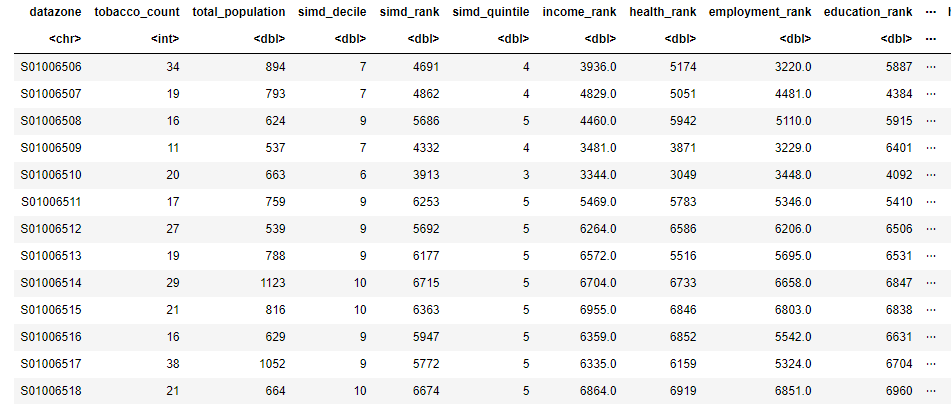

What we are going to do today is showcase how we might approach answering questions like these:

1. Is the number of tobacco retailers in urban areas associated with smoking rates in datazones in Scotland?
2. Is this association independent of the level of deprivation in these datazones?
3. Is the level of deprivation in urban areas datazones associated with the number of tobacco retailers?

A reminder that much of what we are going to be doing is written up in this book by Hadley Wickham which is available online here: https://r4ds.had.co.nz/

It is definitly worth referring to as you learn these techniques! 

## 2. Summarising and visualising

First let's read in the package we need as before

In [ ]:
#First let's load in the package we need as before
library(tidyverse)

And now let's read the data we created in last weeks practical...

In [ ]:
my_data <- read_csv("AnalysisData.csv")

In [ ]:
head(my_data)

### Some variable cleaning and recoding

Next we want to remove all of the missing data using the code below.

In [ ]:
#Remove all missing data
my_data <- my_data %>%
    filter_all(all_vars(!is.infinite(.))) %>%
    filter_all(all_vars(!is.na(.)))

Now we need to create some new variables. First, changing the retailer count into something more useful, second creating a new categorical variables from the access and income rank variables, third a binary variable of whether an area has higher or lower than average smoking rates and a quintile of smoking rate.

We also rename our urban and rural variable to make things easier.

In [ ]:
#Create new variables
my_data <- my_data %>%
    mutate(retailers_adj = (retailer_count/total_population)*778)

my_data <- my_data %>%
    mutate(income_quintile = ntile(income_rank, 5), 
           access_quintile = ntile(access_rank, 5),
           retailers_quintile = ntile(retailers_adj, 5))

#CReate binary smoking rate variable
my_data <- my_data %>% 
    mutate(bin_smoking = ifelse(smoking_rate > 14, 1, 0)) %>%
    mutate(bin_smoking = as.numeric(bin_smoking))

#Rename the urban and rural variable
my_data <- my_data %>%
  rename(urban_rural = "UR6_2013_2014")

This next part is important. We have some categorical variables in our data but R doesnt know this yet...

In [ ]:
head(my_data)

If you look underneath the variable names, they all have `dbl` written below them which stands for double which is a numeric data type. We need R to recognise these as categorical variables or as R calls them, factors...

The code below does this for us using the factor command. But first, we create a set of levels for each of our categorical variables ordered as we want then we apply each of these to the relevant variable. Note the use of the `$` symbol together with the data where the variable can be found. In other words `my_data$urban_rural` means select variable `urban_rural` from `my_data`.

In [ ]:
#Create vectors of levels for our categorical variables
simd_decile_levels <- c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10")
simd_quintile_levels <- c("1", "2", "3", "4", "5")
urban_rural_levels = c("Large Urban", "Other Urban", "Acc Small Towns", "Rem Small Towns", "Acc Rural", "Rem Rural")

#Apply the correctly ordered labels to our variables
my_data$urban_rural <- factor(my_data$urban_rural)
my_data$simd_decile <- factor(my_data$simd_decile, levels = simd_decile_levels)
my_data$simd_quintile <- factor(my_data$simd_quintile, levels = simd_quintile_levels)
my_data$income_quintile <- factor(my_data$income_quintile, levels = simd_quintile_levels)
my_data$access_quintile <- factor(my_data$access_quintile, levels = simd_quintile_levels)
my_data$retailers_quintile <- factor(my_data$retailers_quintile, levels = simd_quintile_levels)
my_data$bin_smoking <- factor(my_data$bin_smoking)

In [ ]:
head(my_data)

Now we can recode the levels of urban_rural with the right labels using `fct_recode()` together with `mutate`.

In [ ]:
#Modify value labels for categorical variables and rename the variable
my_data <- my_data %>%
  mutate(urban_rural = fct_recode(urban_rural,
    "Large Urban" = "1",
    "Other Urban" = "2",
    "Acc Small Towns" = "3",
    "Rem Small Towns" = "4",
    "Acc Rural" = "5",
    "Rem Rural" = "6"))

my_data$urban_rural <- factor(my_data$urban_rural, levels = urban_rural_levels)

In [ ]:
head(my_data)

### Summary statistics and tables

First let's look at some of our categorical variables using `count`.

In [ ]:
#Tables for the categorical variables
my_data %>% 
  count(urban_rural)

my_data %>% 
  count(simd_quintile)

my_data %>% 
  count(simd_decile)

my_data %>% 
  count(simd_quintile)

Now let's look at the continuous variables using `summary()`...

In [ ]:
#Summaries for all of the variables
summary(my_data)

### Plots (boxplots and histograms)

It is also good practice to look at our data using graphs and plots, particularly boxplots and histograms.

Let's look at the `retailers_adj` variable.

In [ ]:
#Histogram and boxplot for the tobacco retailers
ggplot(data = my_data) +
  geom_histogram(mapping = aes(x = retailers_adj), binwidth = 0.5)

ggplot(data = my_data, mapping = aes(retailers_adj)) +
  geom_boxplot()

#Some other plots we might want to look at:

#ggplot(data = my_data) +
#  geom_histogram(mapping = aes(x = smoking_rate), binwidth = 0.1)

Looking at these graphs it seems we need to trim some outlying obervations (removing observations with retailers greater than 100)

In [ ]:
my_data <- my_data %>%
    filter(retailers_adj <= 100)

In many cases, boxplots are more useful when combined with categorical variables...

In [ ]:
ggplot(data = my_data, mapping = aes(x = simd_quintile, y = smoking_rate)) +
  geom_boxplot()

ggplot(data = my_data, mapping = aes(x = retailers_quintile, y = smoking_rate)) +
  geom_boxplot()

ggplot(data = my_data, mapping = aes(x = simd_quintile, y = retailers_adj)) +
  geom_boxplot()

## 3. Linear Regression in R

We have seen a hint of some of the results to our research questions but let's complete our analysis formally using regression.

As a reminder, here are our research questions:

1. Is the number of tobacco retailers associated with smoking rates in datazones in Scotland?
2. Is this association independent of the level of deprivation in these datazones?
3. Is the level of deprivation in datazones associated with the number of tobacco retailers?

Since we are only interested in urban areas let's remove all non-urban areas first...

In [ ]:
#Create a new analysis file
urban_only <- my_data %>%
    filter(urban_rural=="Large Urban" | urban_rural == "Other Urban")

In [ ]:
head(urban_only)

Ok, now we can tackle question 1 using a linear regression: 

In [ ]:
#Run a linear regression model
single_linear_regression <- lm(smoking_rate ~ retailers_adj, data=urban_only, na.action=na.exclude)

This has produced the model and saved it in an object called `single_linear_regression`. We now need to view this output using  summary...

In [ ]:
summary(multiple_linear_regression)

We also want confidence intervals...

In [ ]:
confint(single_linear_regression)

Let's look at research question 2...:

2. Is this association independent of the level of deprivation in these datazones?

In [ ]:
#Add some variables
multiple_linear_regression <- lm(smoking_rate ~ retailers_adj + simd_quintile, data=urban_only, na.action=na.exclude)
summary(multiple_linear_regression)
confint(multiple_linear_regression)

What is going on here? When we add new variables to a model we are essentially adding more dimensions to the data. This can be illustrated by the images below (ignore the axis labels!). The top image is a straightforward linear regression with one outcome and one predictor. The second is a regression with two predictor variables.   

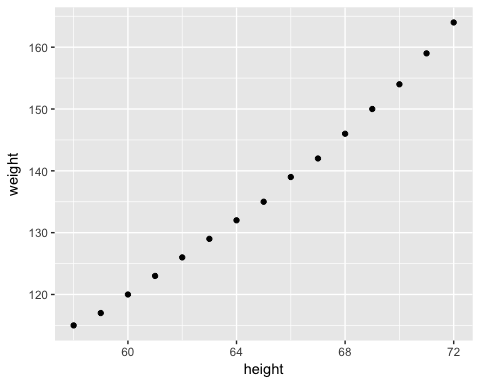 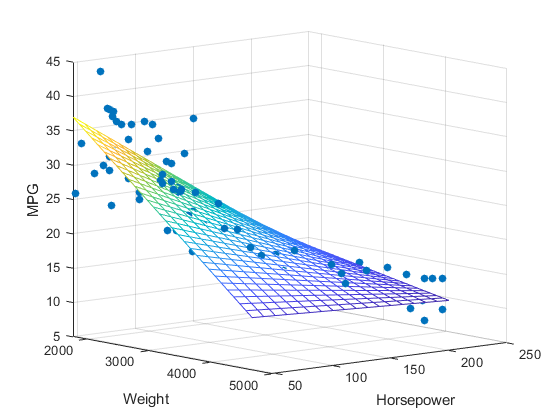

We can also add more than 2 variables (but we cant represent on a graph as you cannot go beyond 3 dimensions!). But the principal is the same. In practical terms what we say is we are "adjusting" or "controlling" for the other variables. In other words, any effects we observe in our model we can say occur "independently" of the other variables. If we had observed a significant effect of tobacco retailers after adjusting for deprivation we would concludethat tobacco retailers are associated with smoking irrespective of the level of deprivation in an area. 

Let's look at research question 3:

3. Is the level of deprivation in datazones associated with the number of tobacco retailers?

To answer let's put all of the different parts of the SIMD into our model (i.e. the income_rank, health_rank, employment_rank, education_rank, access_rank, crime_rank and housing_rank variables)

In [ ]:
#Look at predicting retailers
multiple_linear_regression <- lm(retailers_adj ~ income_rank + 
                                 health_rank + 
                                 employment_rank + 
                                 education_rank + 
                                 access_rank + 
                                 crime_rank + 
                                 housing_rank, 
                                 data=urban_only, na.action=na.exclude)

summary(multiple_linear_regression)
confint(multiple_linear_regression)